Classification for Binary label (Functional and Non-Functional)

100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:24<00:00,  6.15it/s]


Epochs: 1
               Train Loss:  0.255
               Train Accuracy:  0.722
               Val Loss:  0.230
               Val Accuracy:  0.745


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  5.99it/s]


Epochs: 2
               Train Loss:  0.167
               Train Accuracy:  0.854
               Val Loss:  0.184
               Val Accuracy:  0.831


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  5.98it/s]


Epochs: 3
               Train Loss:  0.118
               Train Accuracy:  0.899
               Val Loss:  0.205
               Val Accuracy:  0.809


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  6.01it/s]


Epochs: 4
               Train Loss:  0.090
               Train Accuracy:  0.926
               Val Loss:  0.201
               Val Accuracy:  0.809


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.02it/s]


Epochs: 5
               Train Loss:  0.076
               Train Accuracy:  0.939
               Val Loss:  0.202
               Val Accuracy:  0.818


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:28<00:00,  6.03it/s]


Epochs: 6
               Train Loss:  0.070
               Train Accuracy:  0.939
               Val Loss:  0.205
               Val Accuracy:  0.825


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:31<00:00,  5.95it/s]


Epochs: 7
               Train Loss:  0.066
               Train Accuracy:  0.944
               Val Loss:  0.205
               Val Accuracy:  0.828


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:31<00:00,  5.95it/s]


Epochs: 8
               Train Loss:  0.065
               Train Accuracy:  0.945
               Val Loss:  0.204
               Val Accuracy:  0.838


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:30<00:00,  5.97it/s]


Epochs: 9
               Train Loss:  0.064
               Train Accuracy:  0.949
               Val Loss:  0.206
               Val Accuracy:  0.828


100%|██████████████████████████████████████████████████████████████████████████████| 1256/1256 [03:29<00:00,  6.00it/s]


Epochs: 10
               Train Loss:  0.063
               Train Accuracy:  0.948
               Val Loss:  0.210
               Val Accuracy:  0.831
Test Accuracy:  0.810
Recall for label 0: 67.33%
Precision for label 0: 71.58%
F1 for label 0: 69.39
Recall for label 1: 87.38%
Precision for label 1: 85.00%
F1 for label 1: 86.18


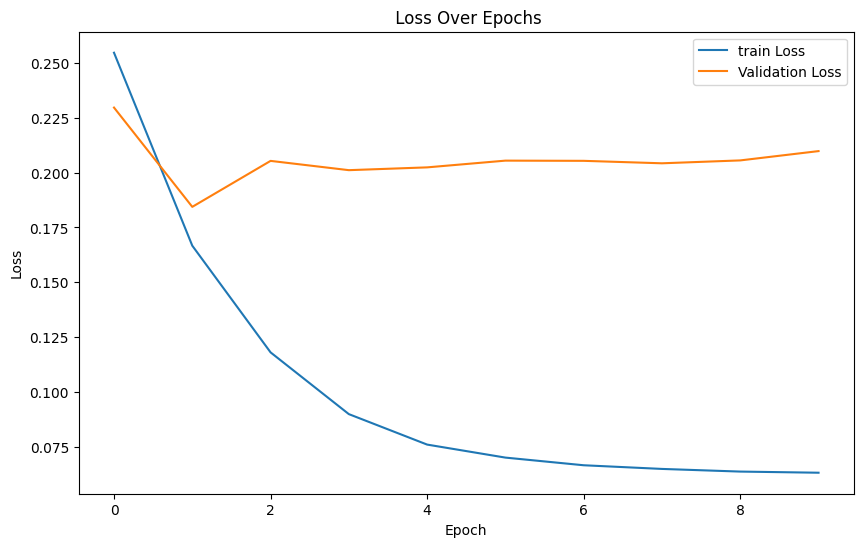

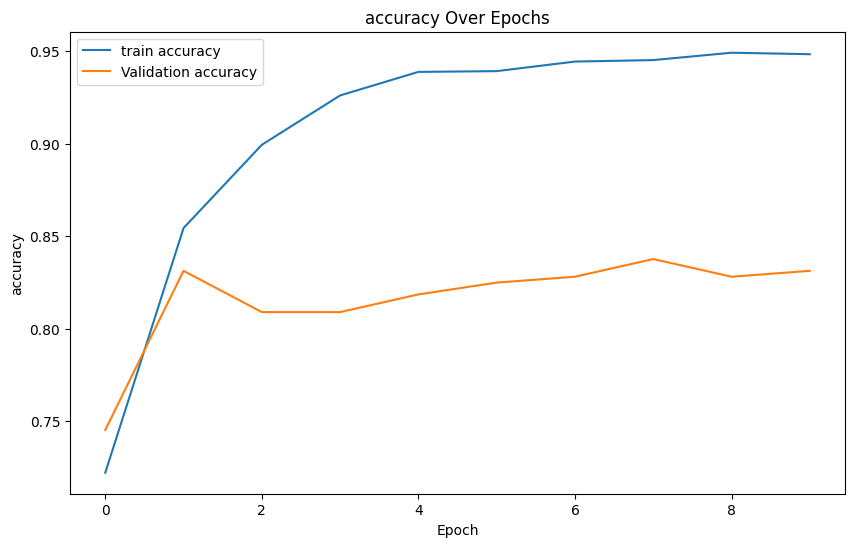

In [1]:
import torch
import numpy as np
from transformers import BertTokenizer,BertModel
import pandas as pd
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

#dataload
df = pd.read_csv('dataset/binary_user_stories.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
          'Functional':0,
          'No-Functional':1
          }

#dataset
class Dataset(Dataset):
    def __init__(self,df):
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt")
                      for text in df['texts']]
        self.labels = [labels[label] for label in df['labels']]


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text,label


# classifier
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer



# train

def train(model,train_data,val_data,learning_rate,epochs):

    train,val = Dataset(train_data),Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr = learning_rate)
    schedular = ExponentialLR(optimizer,gamma=0.5)
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input,train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            print(
                f'''Epochs: {epoch + 1}
               Train Loss: {total_loss_train / len(train_data): .3f}
               Train Accuracy: {total_acc_train / len(train_data): .3f}
               Val Loss: {total_loss_val / len(val_data): .3f}
               Val Accuracy: {total_acc_val / len(val_data): .3f}''')
        schedular.step()












#evaluate
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    model.eval()
    correct_pred = {label:0 for label in labels.values()}
    total_label = {label:0 for label in labels.values()}
    total_pred = {label:0 for label in labels.values()}
    total_acc_test = 0

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              preds = output.argmax(dim=1)
              for label,pred in zip(test_label,preds):
                  total_label[label.item()] += 1 # total sample of this label is counted
                  total_pred[pred.item()] +=1 # total predcit labels
                  if label == pred:
                      correct_pred[label.item()] += 1 # True positive
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    for label, correct_count in correct_pred.items():
        recall = 100 * correct_count / total_label[label] if total_label[label] > 0 else 0
        print(f'Recall for label {label}: {recall:.2f}%')
        precision = 100 * correct_count / total_pred[label] if total_pred[label] > 0 else 0
        print(f'Precision for label {label}: {precision:.2f}%')
        if precision + recall > 0:
            F1_score = 2 * (precision * recall)/(precision + recall)
        else:
            F1_score = 0
        print(f'F1 for label {label}: {F1_score:.2f}')



# main
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])
EPOCHS = 10
model = BertClassifier()
LR = 4e-6
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)



#plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('accuracy Over Epochs')
plt.legend()
plt.show()


Clasification for None-Functional labels

100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:09<00:00,  6.48it/s]


Epochs: 1
              | Train Loss:  0.733
              | Train Accuracy:  0.497
              | Val Loss:  0.652
              | Val Accuracy:  0.550


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:19<00:00,  6.05it/s]


Epochs: 2
              | Train Loss:  0.554
              | Train Accuracy:  0.580
              | Val Loss:  0.546
              | Val Accuracy:  0.597


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:21<00:00,  5.95it/s]


Epochs: 3
              | Train Loss:  0.449
              | Train Accuracy:  0.673
              | Val Loss:  0.522
              | Val Accuracy:  0.706


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:21<00:00,  5.94it/s]


Epochs: 4
              | Train Loss:  0.254
              | Train Accuracy:  0.845
              | Val Loss:  0.347
              | Val Accuracy:  0.782


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:22<00:00,  5.91it/s]


Epochs: 5
              | Train Loss:  0.171
              | Train Accuracy:  0.899
              | Val Loss:  0.322
              | Val Accuracy:  0.810


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:22<00:00,  5.92it/s]


Epochs: 6
              | Train Loss:  0.122
              | Train Accuracy:  0.935
              | Val Loss:  0.302
              | Val Accuracy:  0.815


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:22<00:00,  5.91it/s]


Epochs: 7
              | Train Loss:  0.090
              | Train Accuracy:  0.952
              | Val Loss:  0.329
              | Val Accuracy:  0.820


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:21<00:00,  5.96it/s]


Epochs: 8
              | Train Loss:  0.067
              | Train Accuracy:  0.970
              | Val Loss:  0.301
              | Val Accuracy:  0.834


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:21<00:00,  5.97it/s]


Epochs: 9
              | Train Loss:  0.053
              | Train Accuracy:  0.979
              | Val Loss:  0.306
              | Val Accuracy:  0.829


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [02:21<00:00,  5.97it/s]


Epochs: 10
              | Train Loss:  0.043
              | Train Accuracy:  0.980
              | Val Loss:  0.307
              | Val Accuracy:  0.848
Test Accuracy:  0.782
Recall for label 0: 86.76%
Precision for label 0: 83.10%
F1 for label 0: 84.89
Recall for label 1: 65.00%
Precision for label 1: 65.00%
F1 for label 1: 65.00
Recall for label 2: 79.07%
Precision for label 2: 75.56%
F1 for label 2: 77.27
Recall for label 3: 88.46%
Precision for label 3: 82.14%
F1 for label 3: 85.19
Recall for label 4: 62.50%
Precision for label 4: 58.82%
F1 for label 4: 60.61
Recall for label 5: 91.30%
Precision for label 5: 95.45%
F1 for label 5: 93.33
Recall for label 6: 33.33%
Precision for label 6: 62.50%
F1 for label 6: 43.48


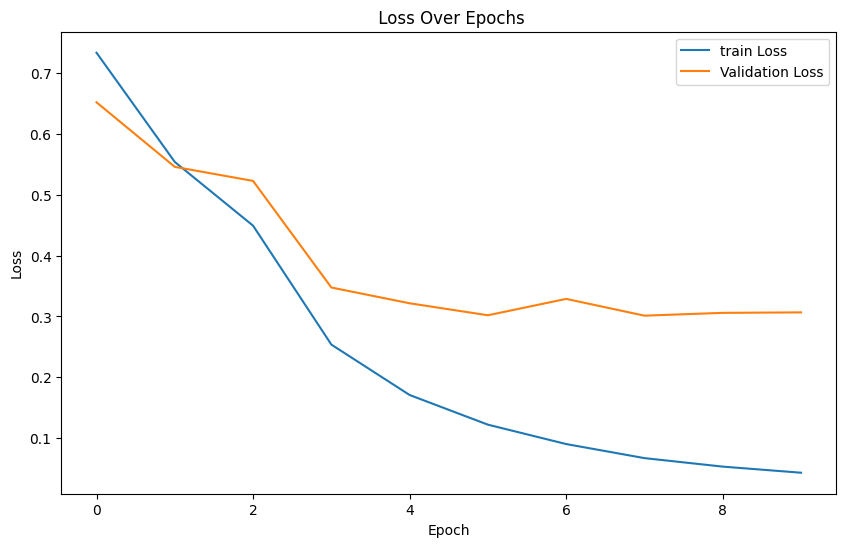

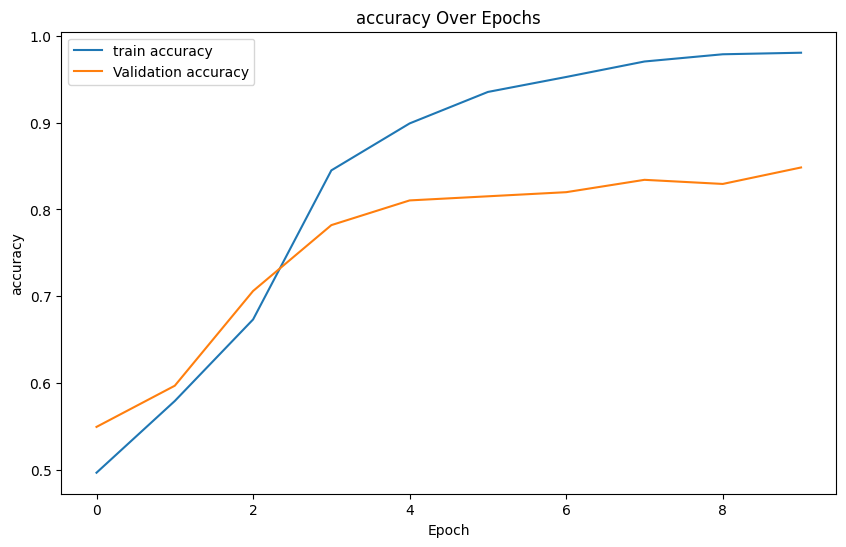

In [3]:
import torch
import numpy as np
from transformers import BertTokenizer,BertModel
import pandas as pd
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
#dataload
df = pd.read_csv('dataset/nf_user_stories.csv')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
        'Usability':0,
          'Maintainability':1,
          'Security':2,
          'Portability':3,
          'Performance':4,
          'Compatibility':5,
          'Reliability':6
          }

#dataset
class Dataset(Dataset):
    def __init__(self,df):
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt")
                      for text in df['texts']]
        self.labels = [labels[label] for label in df['labels']]


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text,label


# classifier
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer



# train
def train(model,train_data,val_data,learning_rate,epochs):

    train,val = Dataset(train_data),Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr = learning_rate)
    schedular = ExponentialLR(optimizer,gamma=0.8)
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input,train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            print(
                f'''Epochs: {epoch + 1}
              | Train Loss: {total_loss_train / len(train_data): .3f}
              | Train Accuracy: {total_acc_train / len(train_data): .3f}
              | Val Loss: {total_loss_val / len(val_data): .3f}
              | Val Accuracy: {total_acc_val / len(val_data): .3f}''')
        schedular.step()

#evaluate
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    model.eval()
    correct_pred = {label:0 for label in labels.values()}
    total_label = {label:0 for label in labels.values()}
    total_pred = {label:0 for label in labels.values()}
    total_acc_test = 0

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              preds = output.argmax(dim=1)
              for label,pred in zip(test_label,preds):
                  total_label[label.item()] += 1 # total sample of this label is counted
                  total_pred[pred.item()] +=1 # total predcit labels
                  if label == pred:
                      correct_pred[label.item()] += 1 # True positive
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    for label, correct_count in correct_pred.items():
        recall = 100 * correct_count / total_label[label] if total_label[label] > 0 else 0
        print(f'Recall for label {label}: {recall:.2f}%')
        precision = 100 * correct_count / total_pred[label] if total_pred[label] > 0 else 0
        print(f'Precision for label {label}: {precision:.2f}%')
        if precision + recall > 0:
            F1_score = 2 * (precision * recall)/(precision + recall)
        else:
            F1_score = 0
        print(f'F1 for label {label}: {F1_score:.2f}')



# main
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])
EPOCHS = 10
model = BertClassifier()
LR = 5e-6
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)



#plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('accuracy Over Epochs')
plt.legend()
plt.show()
